In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import glob
from tensorflow import keras


In [2]:
# detect the image size ...

im = PIL.Image.open("../input/augmented-alzheimer-mri-dataset-v2/data/train/NonDemented/0048efe4-d51d-453c-acaa-3cd6d3f49e50.jpg")
w = im.size[0]
h = im.size[1]

print(f"width: {w}  heighth: {h}")

width: 200  heighth: 190


In [3]:
# process the images ...
mild_demented = glob.glob('../input/augmented-alzheimer-mri-dataset-v2/data/train/MildDemented/*.*')
moderate_demented = glob.glob('../input/augmented-alzheimer-mri-dataset-v2/data/train/ModerateDemented/*.*')
non_demented = glob.glob('../input/augmented-alzheimer-mri-dataset-v2/data/train/NonDemented/*.*')
very_mild_demented = glob.glob('../input/augmented-alzheimer-mri-dataset-v2/data/train/VeryMildDemented/*.*')

data = []
labels = []

for i in mild_demented:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size=(190,200))
    image=np.array(image)
    data.append(image)
    labels.append(0)
for i in moderate_demented:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (190,200))
    image=np.array(image)
    data.append(image)
    labels.append(1)
for i in non_demented:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (190,200))
    image=np.array(image)
    data.append(image)
    labels.append(2)
for i in very_mild_demented:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (190,200))
    image=np.array(image)
    data.append(image)
    labels.append(3)


data = np.array(data)
labels = np.array(labels)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                random_state=42)

# Reserve 1000 samples for validation
x_val = x_train[-1000:]
y_val = y_train[-1000:]
x_train = x_train[:-1000]
y_train = y_train[:-1000]


In [4]:
from keras.applications.xception import Xception

In [5]:
xception_model = Sequential()
pretrained_model= tf.keras.applications.Xception(include_top=False,
                   input_shape=(190,200,3),
                   pooling='avg',classes=4,
                   weights=None)
pretrained_model.load_weights("/kaggle/input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5")
for layer in pretrained_model.layers:
        layer.trainable=True

xception_model.add(pretrained_model)

2022-12-24 22:17:50.611915: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
xception_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
Total params: 20,861,480
Trainable params: 20,806,952
Non-trainable params: 54,528
_________________________________________________________________


In [7]:
xception_model.add(Flatten())
xception_model.add(Dense(512, activation='relu'))
xception_model.add(Dense(4, activation='softmax'))

In [8]:
xception_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
Total params: 21,912,620
Trainable params: 21,858,092
Non-trainable params: 54,528
_________________________________________________________________


In [9]:
xception_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath="mymodel_{epoch}",
        save_best_only=True,  # Only save a model if `val_accuracy` has improved.
        monitor="val_accuracy",
        verbose=1,
    ),
    
]



In [10]:
history = xception_model.fit(x_train, y_train,  validation_data=(x_val,y_val),callbacks=callbacks ,epochs=5)

2022-12-24 22:17:56.593974: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
819/819 [==============================] - 6009s 7s/step - loss: 0.8054 - accuracy: 0.6116 - val_loss: 0.9133 - val_accuracy: 0.5930

Epoch 00001: val_accuracy improved from -inf to 0.59300, saving model to mymodel_1


2022-12-24 23:58:15.946510: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
819/819 [==============================] - 5992s 7s/step - loss: 0.2492 - accuracy: 0.9007 - val_loss: 0.5044 - val_accuracy: 0.8200

Epoch 00002: val_accuracy improved from 0.59300 to 0.82000, saving model to mymodel_2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/5
819/819 [==============================] - 6007s 7s/step - loss: 0.0929 - accuracy: 0.9666 - val_loss: 0.2042 - val_accuracy: 0.9300

Epoch 00003: val_accuracy improved from 0.82000 to 0.93000, saving model to mymodel_3


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/5
819/819 [==============================] - 6041s 7s/step - loss: 0.0651 - accuracy: 0.9770 - val_loss: 0.5860 - val_accuracy: 0.8410

Epoch 00004: val_accuracy did not improve from 0.93000
Epoch 5/5
819/819 [==============================] - 6061s 7s/step - loss: 0.0630 - accuracy: 0.9803 - val_loss: 0.0905 - val_accuracy: 0.9720

Epoch 00005: val_accuracy improved from 0.93000 to 0.97200, saving model to mymodel_5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


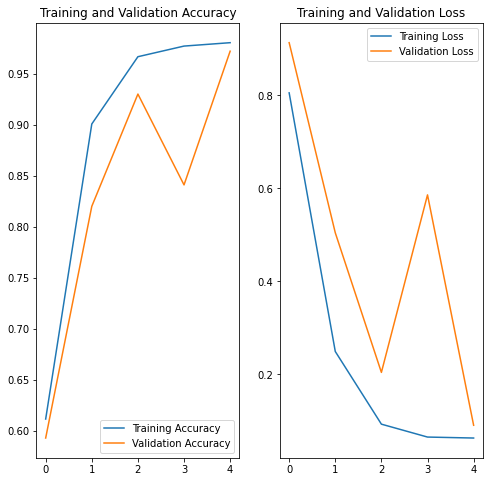

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
# prediction ...

img = tf.keras.utils.load_img("../input/augmented-alzheimer-mri-dataset-v2/data/train/ModerateDemented/00cece55-8382-4430-a91d-b4c39fab6f9a.jpg", target_size = (190,200))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = xception_model.predict(img_array)

score = tf.nn.softmax(predictions[0])

print(score)

tf.Tensor([0.17487772 0.47536692 0.17487772 0.17487772], shape=(4,), dtype=float32)
